### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler 
from factor_analyzer import FactorAnalyzer

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.sum(), x.mean(), x.median(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), x.quantile(0.90),x.quantile(0.95), 
                      x.quantile(0.99),x.max(),x.skew(),x.kurt(), x.std(), x.var(), (x==0).sum(), (x==0).sum()*100/len(x),
                      x.isnull().sum(),x.isnull().sum()*100/len(x) ], 
                  index = ['N', 'SUM', 'MEAN','MEDIAN', 'MIN', 'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,
                          'P95' ,'P99' ,'MAX','SKEW' ,'KURT' ,'STD', 'VAR', 'ZEROS' ,'%ZEROS', 'NMISS', '%NMISS'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [5]:
# To get a reduced heatmap with columns that only have a correlation above the given threshold
def trimmed_corr(df, thresh):
    df_corr=df.corr().abs()
    for col in df_corr.columns:
        df_corr[col][col]=0
    high_corr=df_corr.max()[df_corr.max()>thresh].index
    print('\n**************** FEATURES OF INTEREST ****************\n')
    print(high_corr)
    print('\n******************************************************\n')
    plt.figure(figsize=(15,15), dpi=150)
    sns.heatmap(df[high_corr].corr(), square=True, linewidths=1, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.show()

### Importing the data

In [6]:
df = pd.read_csv('CC_GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
# Since customer ID is the first column that needs to go
df.drop(columns='CUST_ID',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

### Data Exploration

In [8]:
# Since all features are numeric

df.apply(continuous_var_summary).T

,N,SUM,MEAN,MEDIAN,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX,SKEW,KURT,STD,VAR,ZEROS,%ZEROS,NMISS,%NMISS
BALANCE,8950.0,1.400205e+07,1564.474828,873.385231,0.000000,0.065101,8.814518,23.575529,128.281915,873.385231,2054.140036,4338.563657,5909.111808,9338.804814,19043.13856,2.393386,7.674751,2081.531879,4.332775e+06,80.0,0.893855,0.0,0.000000
BALANCE_FREQUENCY,8950.0,7.851573e+03,0.877271,1.000000,0.000000,0.090909,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,-2.023266,3.092370,0.236904,5.612351e-02,80.0,0.893855,0.0,0.000000
PURCHASES,8950.0,8.978683e+06,1003.204834,361.280000,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3998.619500,8977.290000,49039.57000,8.144269,111.388771,2136.634782,4.565208e+06,2044.0,22.837989,0.0,0.000000
ONEOFF_PURCHASES,8950.0,5.302314e+06,592.437371,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2671.094000,6689.898200,40761.25000,10.045083,164.187572,1659.887917,2.755228e+06,4302.0,48.067039,0.0,0.000000
INSTALLMENTS_PURCHASES,8950.0,3.679055e+06,411.067645,89.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1750.087500,3886.240500,22500.00000,7.299120,96.575178,904.338115,8.178274e+05,3916.0,43.754190,0.0,0.000000
CASH_ADVANCE,8950.0,8.760896e+06,978.871112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4647.169122,9588.163357,47137.21176,5.166609,52.899434,2097.163877,4.398096e+06,4628.0,51.709497,0.0,0.000000
PURCHASES_FREQUENCY,8950.0,4.388637e+03,0.490351,0.500000,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.00000,0.060164,-1.638631,0.401371,1.610985e-01,2043.0,22.826816,0.0,0.000000
ONEOFF_PURCHASES_FREQUENCY,8950.0,1.811996e+03,0.202458,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.00000,1.535613,1.161846,0.298336,8.900441e-02,4302.0,48.067039,0.0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,3.261714e+03,0.364437,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.00000,0.509201,-1.398632,0.397448,1.579647e-01,3915.0,43.743017,0.0,0.000000
CASH_ADVANCE_FREQUENCY,8950.0,1.209541e+03,0.135144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.833333,1.50000,1.828686,3.334734,0.200121,4.004857e-02,4628.0,51.709497,0.0,0.000000


### Outlier treatment

In [9]:
df = df.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

### Missing Values

In [10]:
mask = df.isnull()
total = mask.sum()
percent = 100*mask.mean()

missing_data = pd.concat([total, percent], axis=1,join='outer',
                         keys=['count_missing', 'perc_missing'])
missing_data.sort_values(by='perc_missing', ascending=False, inplace=True)

missing_data[missing_data.count_missing > 0]

,count_missing,perc_missing
MINIMUM_PAYMENTS,313,3.497207
CREDIT_LIMIT,1,0.011173


3.5% of Minimum_Payments and 0.011% of Credit_Limits values are missing.

To treat for the missing values in Minimum_Payments shall impute with median values of Minimum Payments and will drop the one missing value of Credit Limit.

In [11]:
df = df.apply(missing_imputation)
df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


**************** FEATURES OF INTEREST ****************

Index(['PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX'],
      dtype='object')

******************************************************



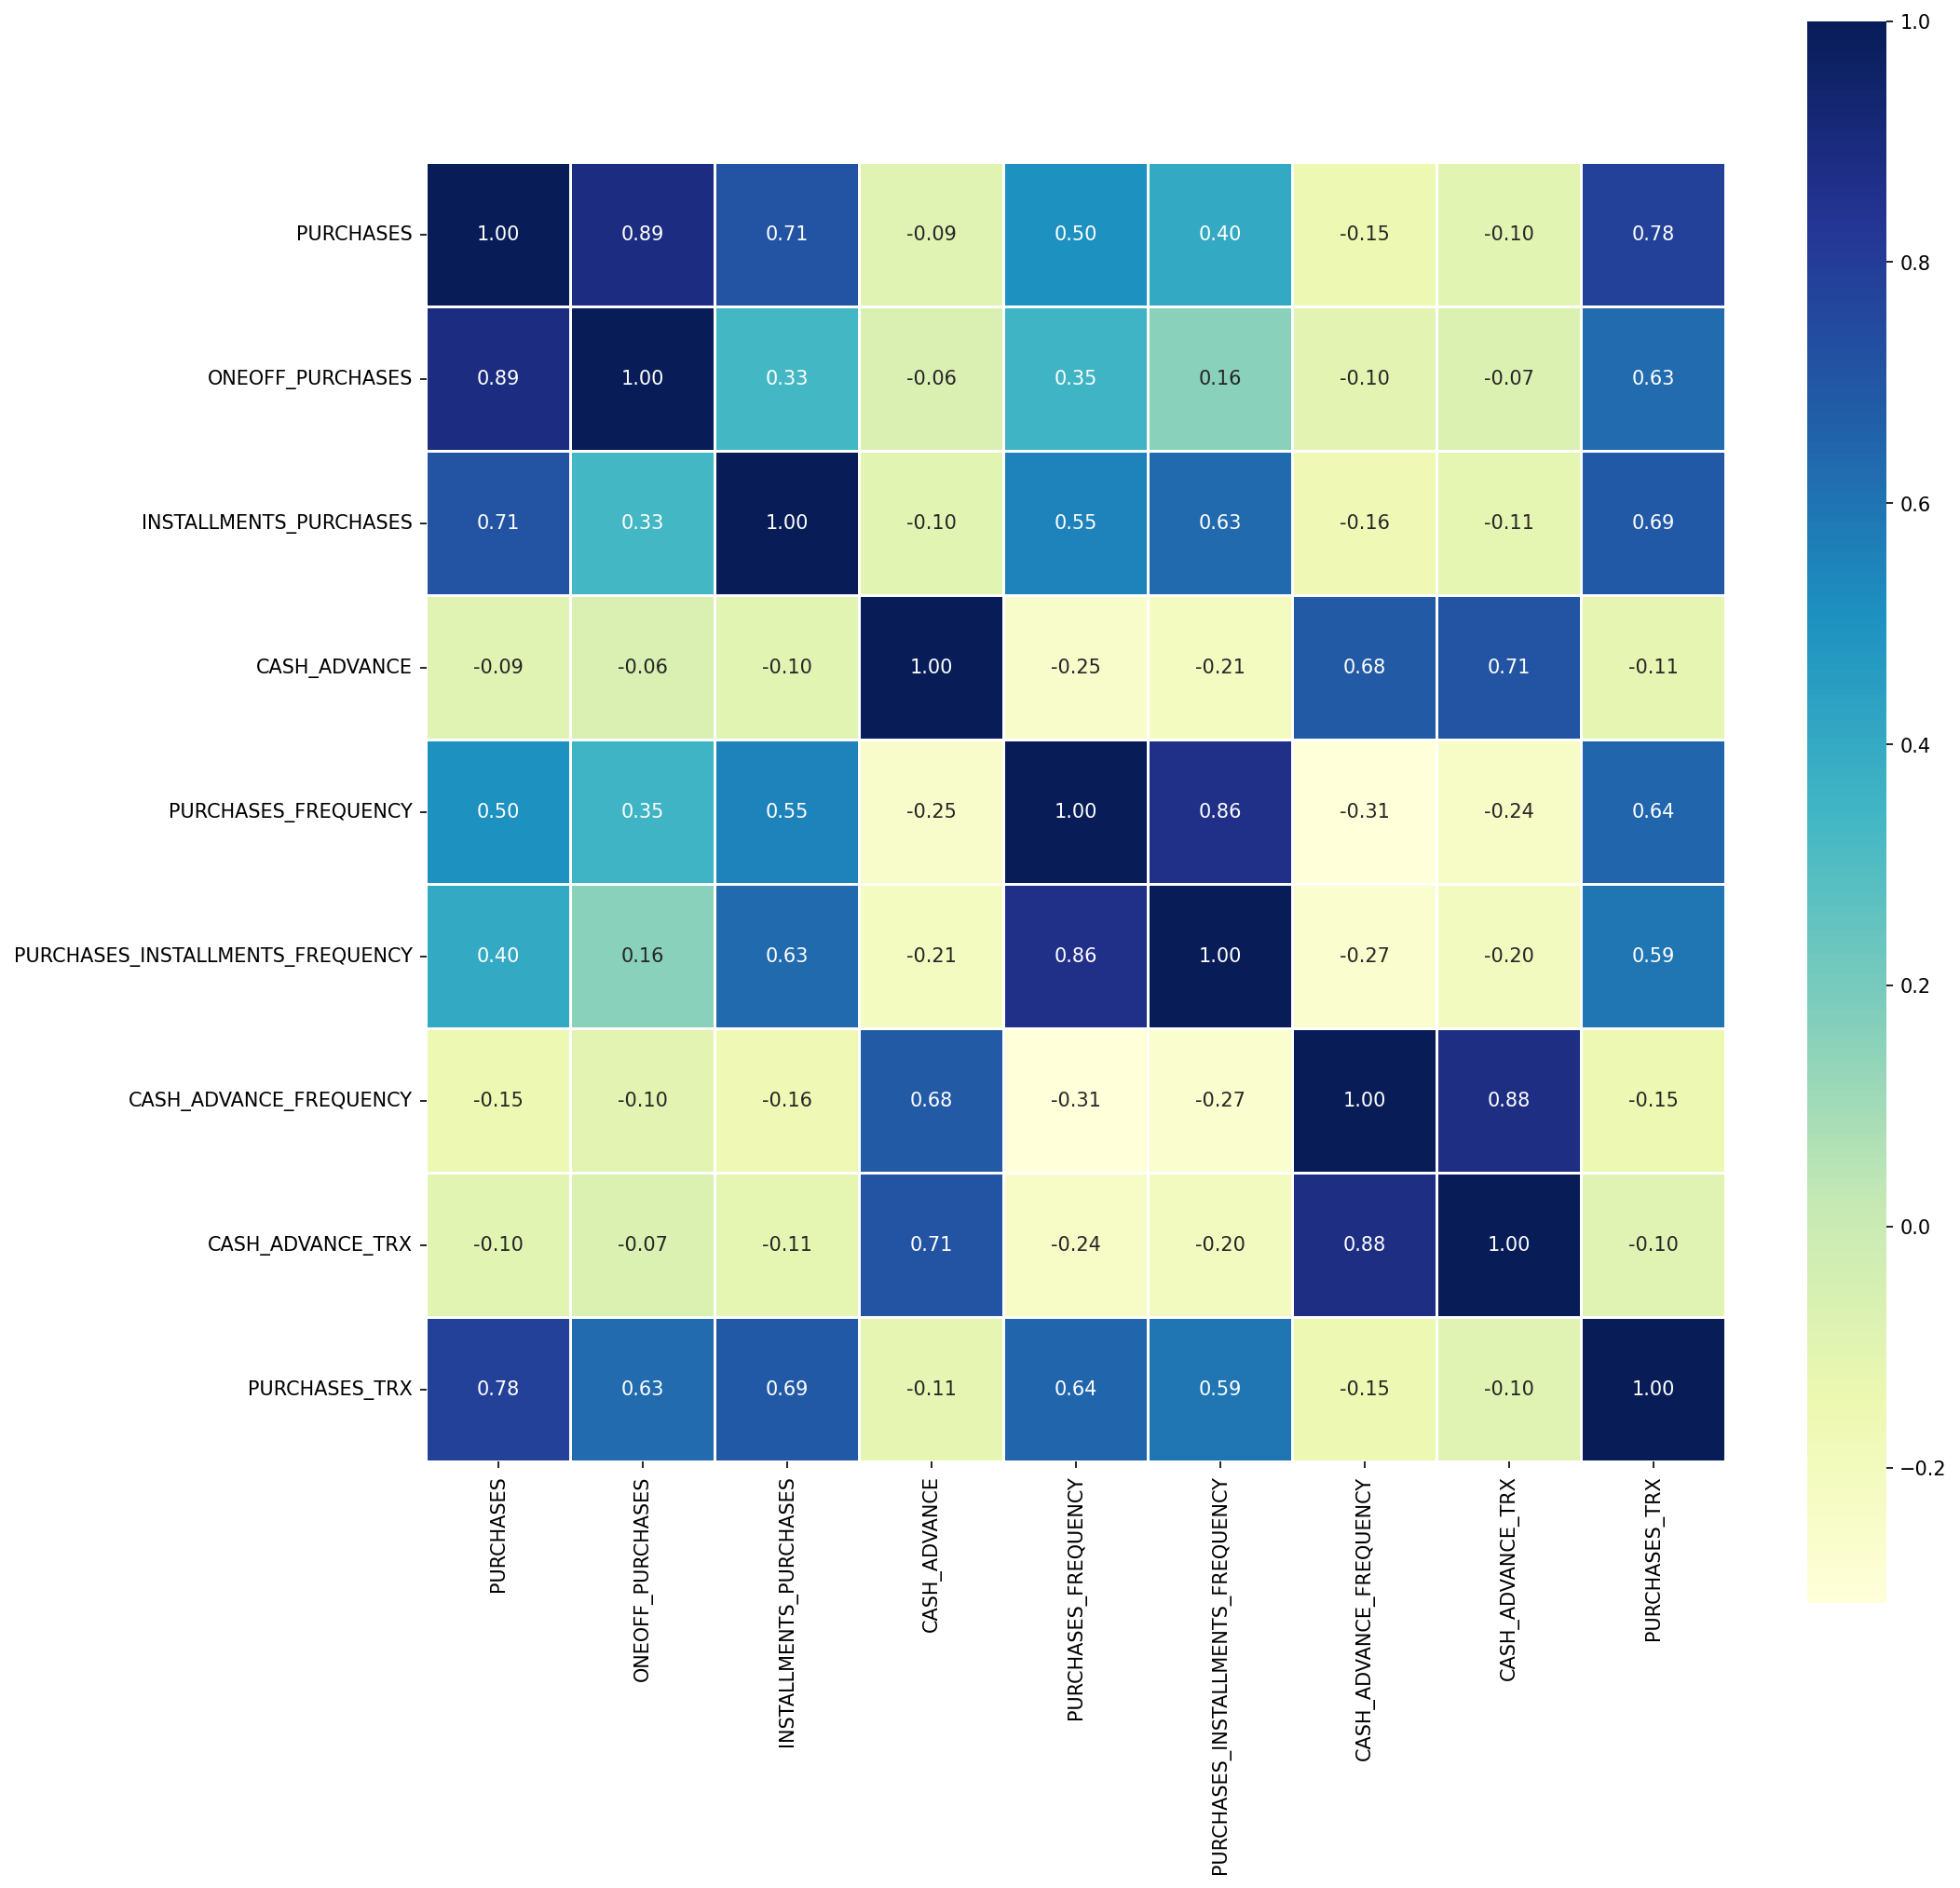

In [12]:
trimmed_corr(df,0.7)

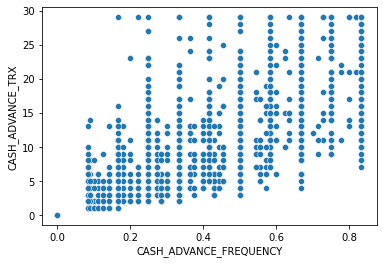

In [13]:
sns.scatterplot(data=df, x='CASH_ADVANCE_FREQUENCY', y='CASH_ADVANCE_TRX');

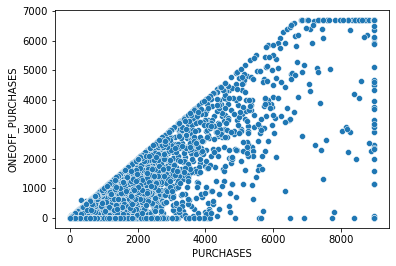

In [14]:
sns.scatterplot(data=df, x='PURCHASES', y='ONEOFF_PURCHASES');

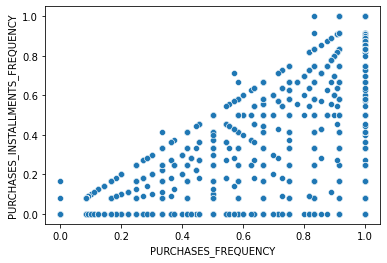

In [15]:
sns.scatterplot(data=df, x='PURCHASES_FREQUENCY', y='PURCHASES_INSTALLMENTS_FREQUENCY');

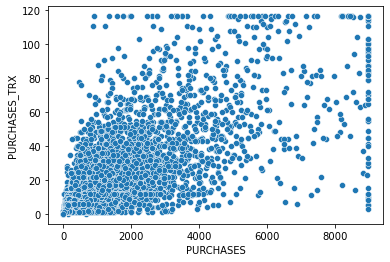

In [16]:
sns.scatterplot(data=df, x='PURCHASES', y='PURCHASES_TRX');

#### None of the correlations are significant enough to elimitate any feature just yet

### Exploring some useful KPIs to better understand customer profiles

### Monthly Average Purchase

In [17]:
# adding Monthly Average Purchase to the df 
df['Monthly_Avg_Purchase'] = df['PURCHASES']/df['TENURE']

---

### Monthly Average Cash Advance Amount

In [18]:
# adding Monthly Average Cash Advance Amount to the df 
df['Monthly_Avg_Cash'] = df['CASH_ADVANCE']/df['TENURE']

--------

### Division of Customers based on the type of Purchases (One-Off, Installments)

To understand how the customers spend on the basis of the type of purchases: One-Off purchase, do they make purchases on installments. They are spender of both the categories or none. 

In [19]:
df['Purchase_Type']=np.where((df['INSTALLMENTS_PURCHASES']>0) & (df['ONEOFF_PURCHASES']==0),'installment',
                                        np.where((df['INSTALLMENTS_PURCHASES']==0) & (df['ONEOFF_PURCHASES']>0),'oneoff',
                                               np.where((df['INSTALLMENTS_PURCHASES']>0) & (df['ONEOFF_PURCHASES']>0),'both','cash')))

In [20]:
# Purchase Type Categories are as follows:
print('\n--------- PERCENTAGE DITRIBUTION ---------\n')
df['Purchase_Type'] .value_counts()*100/len(df)


--------- PERCENTAGE DITRIBUTION ---------



both           30.994413
installment    25.251397
cash           22.815642
oneoff         20.938547
Name: Purchase_Type, dtype: float64

### Inference:

There are 31% of the customers who make purchases for both the types: One Off and Installment Purchases followed by 25.3% customer who make only installment purchases.

In [21]:
# dropping these features since sufficient information has been extracted
df.drop(columns=['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES'],inplace=True)

---------

### Estimating the Limit Usage of customers

Computing the ratio of balance to credit limit to estimate the balance-to-limit ratio for each customer. Balance-to-Limit-ratio is also known as the utilization rate. A higher utilization rate indicates presense of credit risk. Hence, a lower utilization rate (balance-to-limit ratio) is desirable. 

In [22]:
df['Limit_Usage'] = df['BALANCE']/df['CREDIT_LIMIT']

In [23]:
# dropping these features since sufficient information has been extracted
df.drop(columns=['BALANCE'],inplace=True)

### Payments to Minimum_Payments Ratio

In [24]:
df['Pay_to_MinimumPay'] = df['PAYMENTS']/df['MINIMUM_PAYMENTS']

In [25]:
# dropping these features since sufficient information has been extracted
df.drop(columns=['MINIMUM_PAYMENTS','PAYMENTS'],inplace=True)

----------

### Insights using KPIs

To gain insights on the customer profiles, shall explore the data using the Purchase_Type feature over other attributes to understand how the customers behave.

### Pay_to_MinimumPay over Purchase Type

In [26]:
t1 = df.groupby(by=['Purchase_Type'])['Pay_to_MinimumPay'].mean().sort_values(ascending=False)
t1

Purchase_Type
both           7.043546
cash           5.432657
oneoff         5.185968
installment    3.997427
Name: Pay_to_MinimumPay, dtype: float64

##### Customers who made the both kind of purchases paid the highest average minimum payment dues.

### Balance to Credit Limit ratio (or Utilization rate) over Purchase Type

In [27]:
t2 = df.groupby(['Purchase_Type'])['Limit_Usage'].mean().sort_values(ascending = True).reset_index()
t2

,Purchase_Type,Limit_Usage
0,installment,0.270450
1,both,0.351471
2,oneoff,0.379007
3,cash,0.563893


##### A lower balance-to-limit ratio is desirable which indicates there is low credit risk. The customers who make installment purchases have the lowest utilization rate. 

### Monthly_Avg_Purchase over Purchase Type

In [28]:
t3 = df.groupby(by=['Purchase_Type'])['Monthly_Avg_Purchase'].mean().sort_values(ascending=False) 
t3

Purchase_Type
both           176.861350
oneoff          67.284704
installment     46.139936
cash             0.000000
Name: Monthly_Avg_Purchase, dtype: float64

##### The customers who made both the one off and installment purchases have made the highhest total average purchase amount over the last 12 months.

### Monthly_Cash_Advance over Purchase Type

In [29]:
t4 = df.groupby(['Purchase_Type'])['Monthly_Avg_Cash'].mean().sort_values(ascending=False).reset_index()
t4

,Purchase_Type,Monthly_Avg_Cash
0,cash,176.996706
1,oneoff,76.770332
2,both,62.972375
3,installment,36.722734


##### The customers who made neither the one off purchase nor the installments purchase have made the highest monthly average cash in advance amount. 

#### To inspect if the new features have caused any extreme correlations


**************** FEATURES OF INTEREST ****************

Index(['PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'Monthly_Avg_Purchase',
       'Monthly_Avg_Cash'],
      dtype='object')

******************************************************



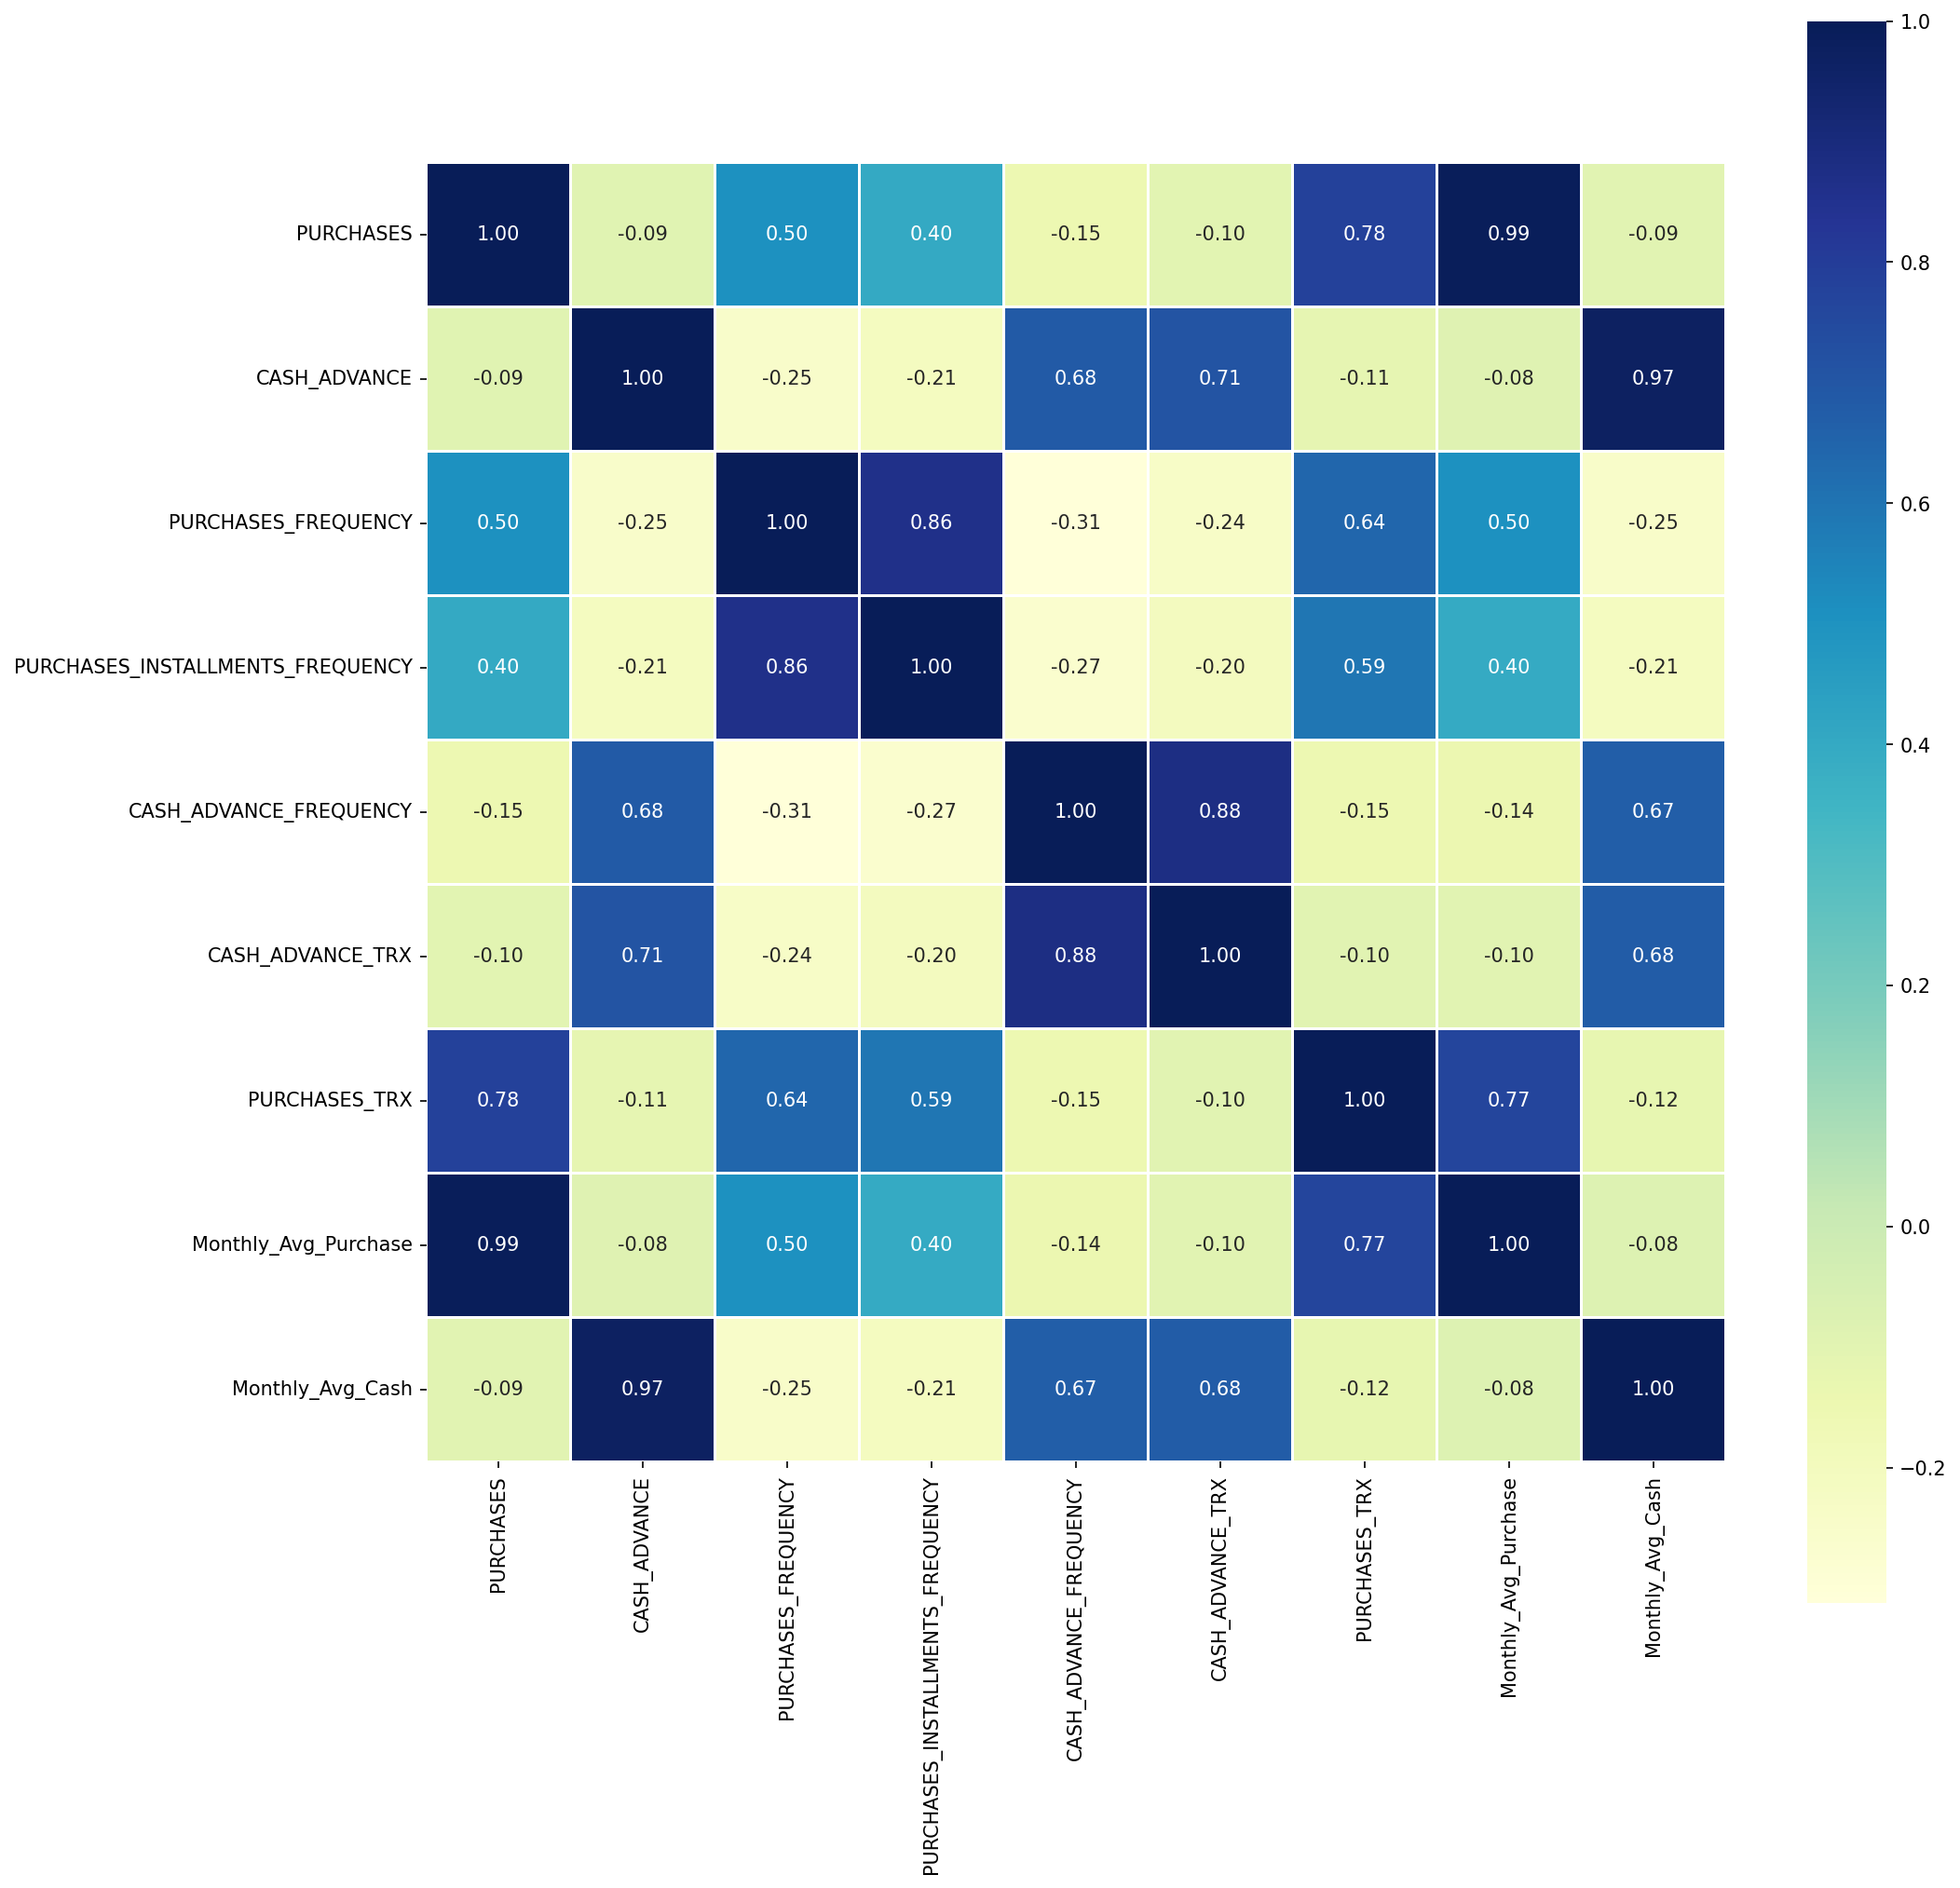

In [30]:
trimmed_corr(df,0.7)

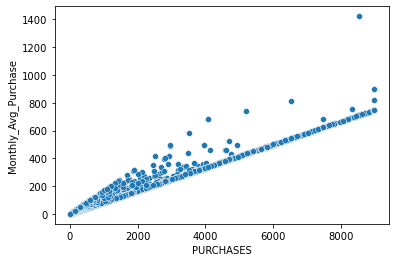

In [31]:
sns.scatterplot(data=df, x='PURCHASES', y='Monthly_Avg_Purchase');

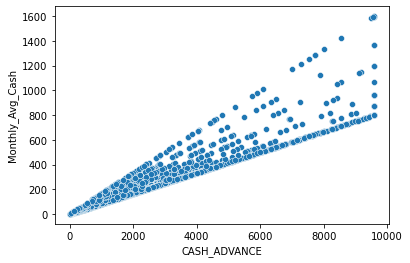

In [32]:
sns.scatterplot(data=df, x='CASH_ADVANCE', y='Monthly_Avg_Cash');

In [33]:
# Replacing PURCHASES & CASH_ADVANCE with their aggregated counterparts, and tenure since its now redundant 
df.drop(columns=['PURCHASES', 'CASH_ADVANCE', 'TENURE'], inplace=True)

### Correlation Matrix

To find the relationships between the features, plotting the correlation matirx:

Dropping the original variables 'BALANCE','PURCHASES','PAYMENTS','MINIMUM_PAYMENTS','TENURE','CASH_ADVANCE' which were used to create the new variables. These variables will be correlated with derived variables increasing the redudancy in the data.

In [34]:
corr_df = df.corr()
corr_df

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Avg_Cash,Limit_Usage,Pay_to_MinimumPay
BALANCE_FREQUENCY,1.000000,0.232890,0.202845,0.179472,0.193894,0.162818,0.212610,0.098321,-0.098040,0.166118,0.090456,0.447095,-0.162066
PURCHASES_FREQUENCY,0.232890,1.000000,0.501343,0.862934,-0.312493,-0.238395,0.642234,0.119603,0.305802,0.504246,-0.245552,-0.217578,0.045635
ONEOFF_PURCHASES_FREQUENCY,0.202845,0.501343,1.000000,0.142329,-0.113575,-0.081339,0.601289,0.296099,0.157531,0.606508,-0.105320,-0.099701,0.107096
PURCHASES_INSTALLMENTS_FREQUENCY,0.179472,0.862934,0.142329,1.000000,-0.265907,-0.200169,0.593674,0.060237,0.250087,0.396285,-0.206060,-0.174508,0.029228
CASH_ADVANCE_FREQUENCY,0.193894,-0.312493,-0.113575,-0.265907,1.000000,0.881092,-0.151307,0.134741,-0.253292,-0.143088,0.670232,0.391003,-0.054092
CASH_ADVANCE_TRX,0.162818,-0.238395,-0.081339,-0.200169,0.881092,1.000000,-0.096709,0.160612,-0.201056,-0.096095,0.677050,0.325136,-0.042854
PURCHASES_TRX,0.212610,0.642234,0.601289,0.593674,-0.151307,-0.096709,1.000000,0.280397,0.179559,0.768456,-0.118566,-0.064353,0.108358
CREDIT_LIMIT,0.098321,0.119603,0.296099,0.060237,0.134741,0.160612,0.280397,1.000000,0.053164,0.359494,0.288888,-0.146380,0.093833
PRC_FULL_PAYMENT,-0.098040,0.305802,0.157531,0.250087,-0.253292,-0.201056,0.179559,0.053164,1.000000,0.203483,-0.173734,-0.462825,0.202232
Monthly_Avg_Purchase,0.166118,0.504246,0.606508,0.396285,-0.143088,-0.096095,0.768456,0.359494,0.203483,1.000000,-0.079702,-0.086590,0.173342


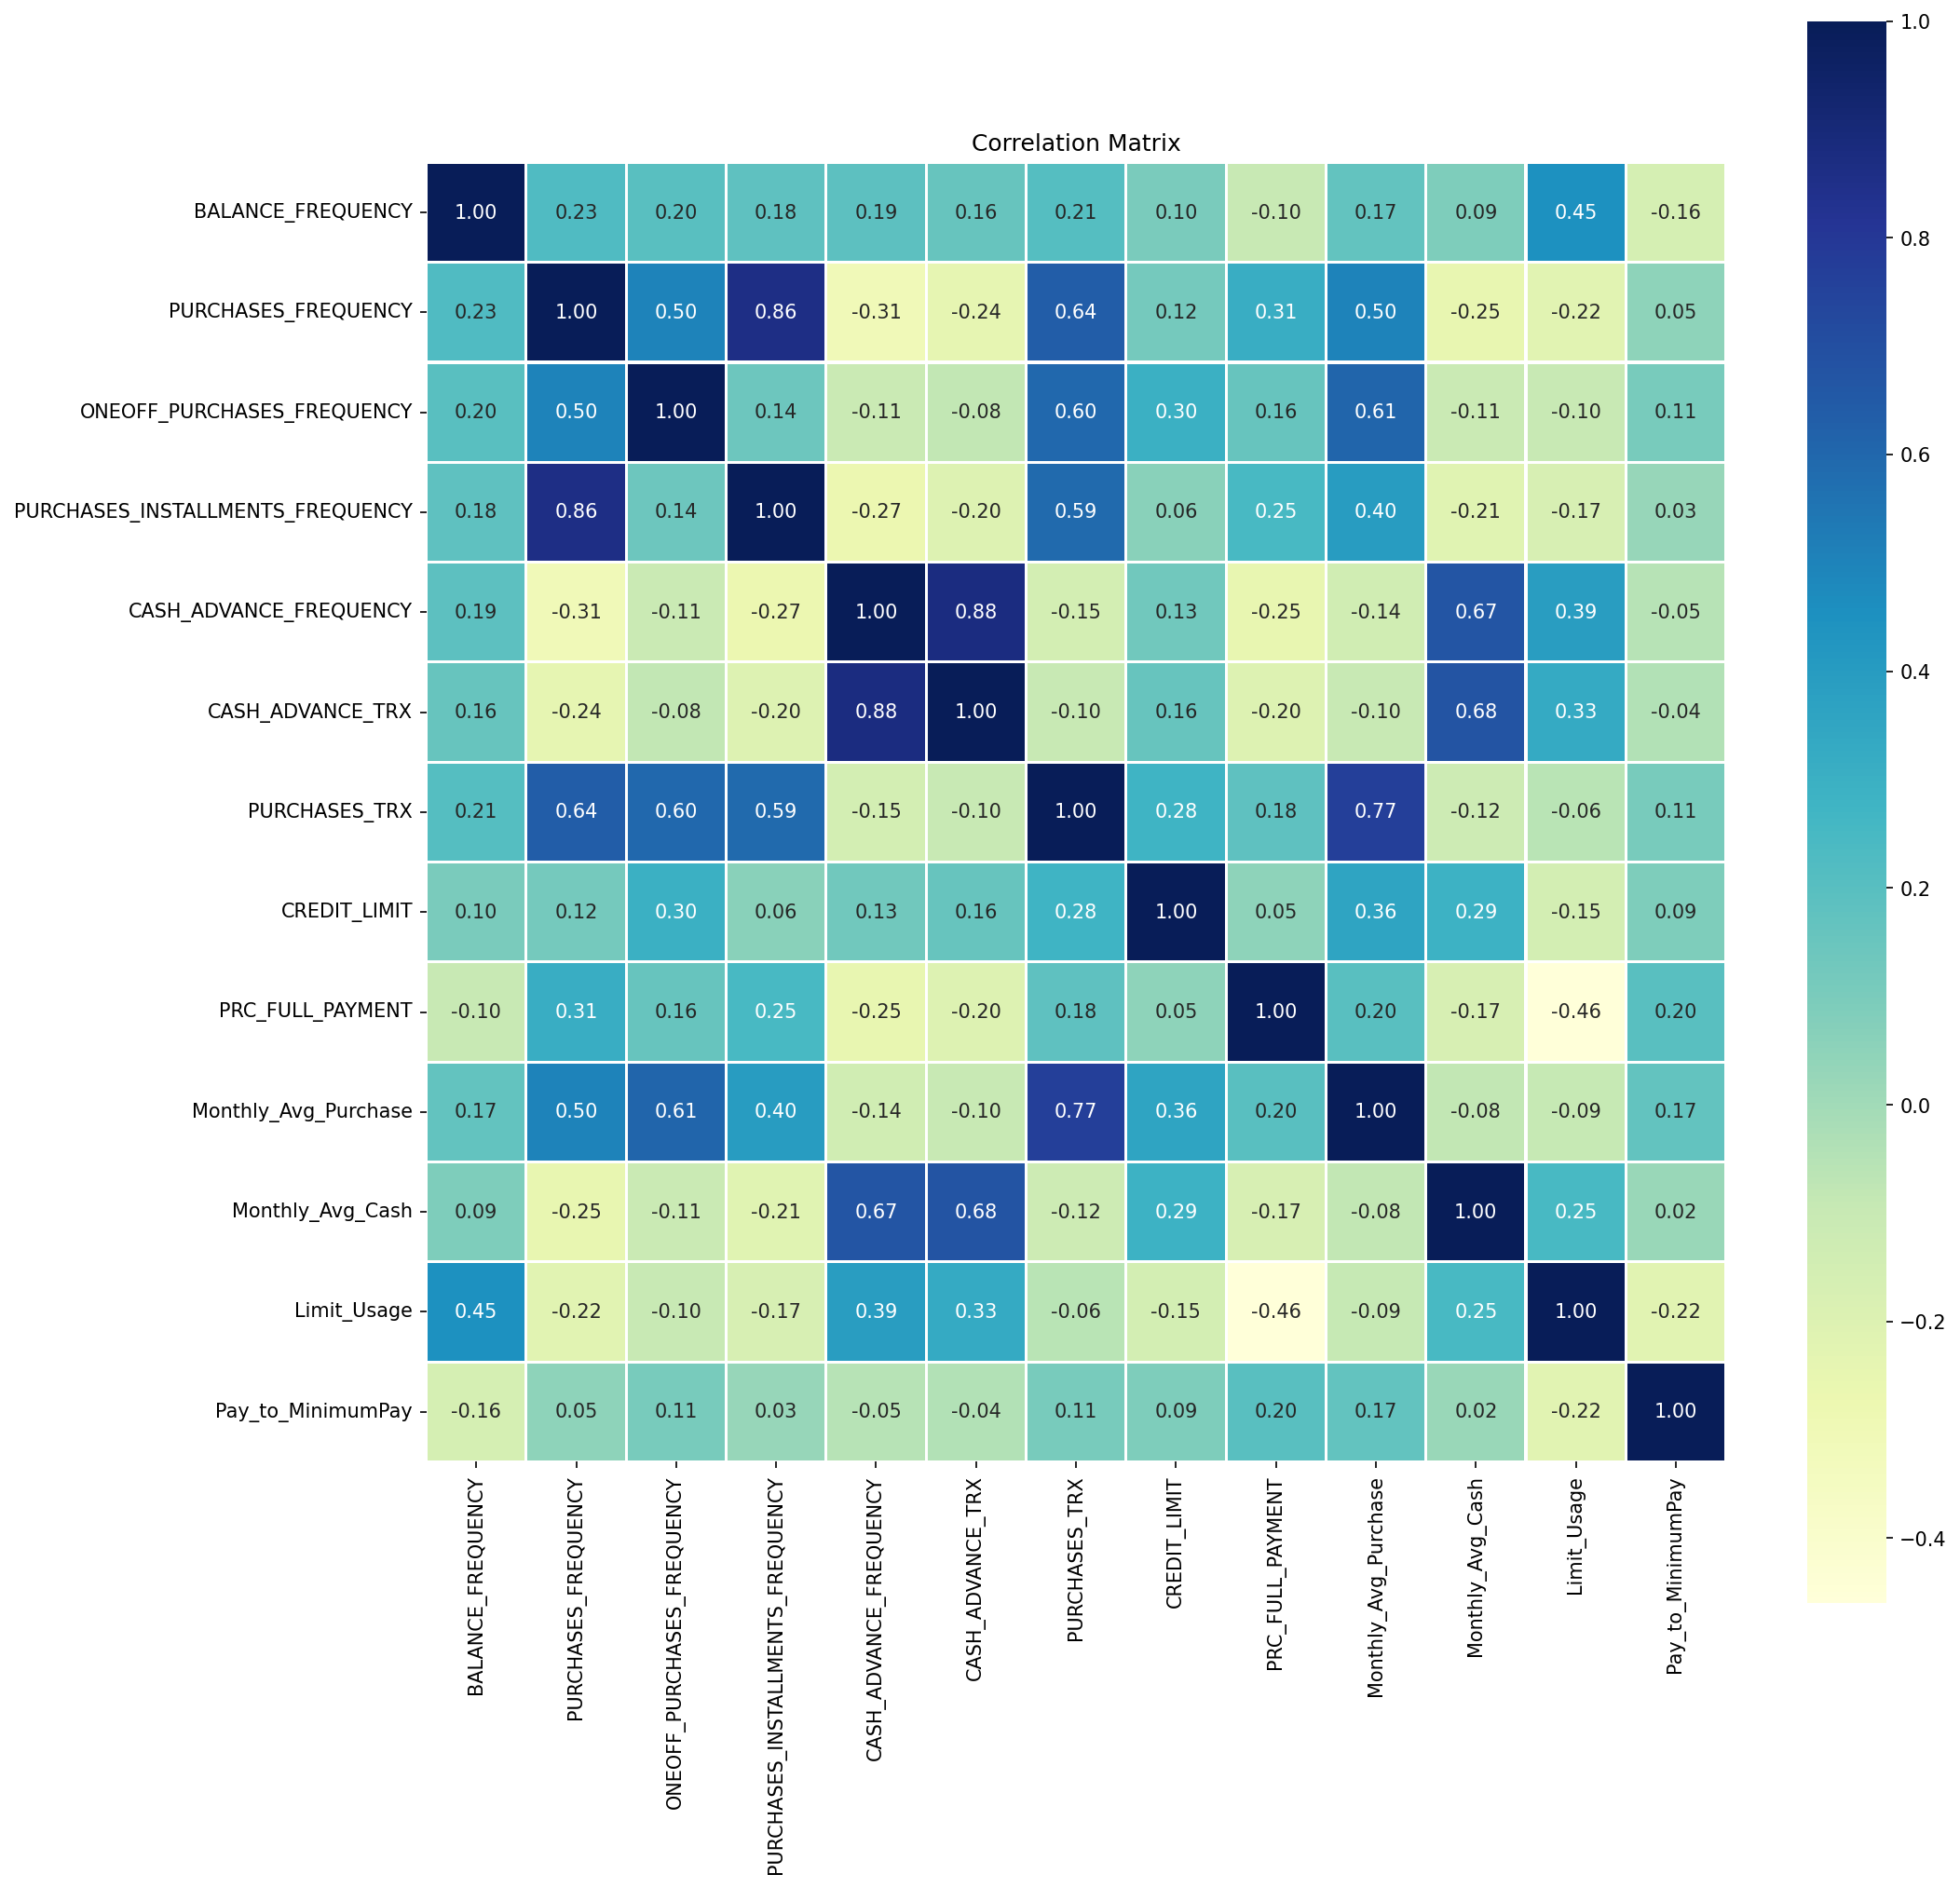

In [35]:
### finding Correlation among the variables:

plt.figure(figsize=(15,15), dpi=150)
sns.heatmap(round(df.corr(),2),annot=True, square=True, cmap='YlGnBu', linewidths=1, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Preparing the data for Modeling

In [36]:
# Creating dummy variables for Purchase_Type 

df = pd.get_dummies(df, columns=['Purchase_Type'], drop_first=False)
df.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Avg_Cash,Limit_Usage,Pay_to_MinimumPay,Purchase_Type_both,Purchase_Type_cash,Purchase_Type_installment,Purchase_Type_oneoff
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,0.000000,7.950000,0.000000,0.040901,1.446508,0,0,1,0
1,0.909091,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,0.222222,0.000000,536.912124,0.457495,3.826241,0,1,0,0
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,0.000000,64.430833,0.000000,0.332687,0.991682,0,0,0,1
3,0.636364,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,124.916667,17.149001,0.222223,0.000000,0,0,0,1
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,0.000000,1.333333,0.000000,0.681429,2.771075,0,0,0,1


In [37]:
scaler = StandardScaler()

df_unscaled = df.copy()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Avg_Cash,Limit_Usage,Pay_to_MinimumPay,Purchase_Type_both,Purchase_Type_cash,Purchase_Type_installment,Purchase_Type_oneoff
0,-0.255968,-0.806490,-0.678661,-0.707313,-0.685371,-0.557505,-0.579714,-0.978471,-0.525551,-0.559583,-0.510509,-0.979686,-0.268383,-0.670193,-0.543690,1.720516,-0.514625
1,0.132501,-1.221758,-0.678661,-0.916995,0.593147,0.166685,-0.675130,0.711257,0.234227,-0.620854,2.704783,0.205564,-0.111512,-0.670193,1.839282,-0.581221,-0.514625
2,0.520970,1.269843,2.673451,-0.916995,-0.685371,-0.557505,-0.102638,0.852068,-0.525551,-0.124282,-0.510509,-0.149528,-0.298365,-0.670193,-0.543690,-0.581221,1.943162
3,-1.032906,-1.014125,-0.399319,-0.916995,-0.259200,-0.376457,-0.627422,0.852068,-0.525551,0.341886,-0.407813,-0.463808,-0.363736,-0.670193,-0.543690,-0.581221,1.943162
4,0.520970,-1.014125,-0.399319,-0.916995,-0.685371,-0.557505,-0.627422,-0.922146,-0.525551,-0.610578,-0.510509,0.842675,-0.181068,-0.670193,-0.543690,-0.581221,1.943162


### Applying PCA

Will be performing Prinicipal Component Analysis(PCA) to reduce the dimensions.

In [38]:
from sklearn.decomposition import PCA

### PCA using sklearn:

As we don't know how many components we want hence will start with all the 17 features and will see post fitting the model the eigen values i.e. the explained variance captured by each of the new components (or eigen vectors).

In [52]:
df.shape

(8950, 17)

In [45]:
pca_model = PCA(n_components = 17)
X_PCA = pca_model.fit_transform(df)

In [46]:
X_PCA.shape

(8950, 17)

In [47]:
# Cumulative Variance explained:
pca_var = pca_model.explained_variance_
np.cumsum(pca_var)

array([ 4.78249558,  7.78367432,  9.69566314, 11.25650935, 12.44734371,
       13.28952106, 14.0738291 , 14.81924185, 15.41963411, 15.79271341,
       16.13552033, 16.43494291, 16.68463225, 16.85707238, 16.96756203,
       17.00189965, 17.00189965])

In [48]:
# Cumulative Variance explained ratio:
pca_var_ratio = pca_model.explained_variance_ratio_
np.cumsum(pca_var_ratio)

array([0.28129184, 0.45781204, 0.5702694 , 0.66207363, 0.73211488,
       0.78164919, 0.8277798 , 0.87162271, 0.90693596, 0.92887934,
       0.9490422 , 0.96665333, 0.9813393 , 0.9914817 , 0.99798037,
       1.        , 1.        ])

In [49]:
# Cumulative Variance explains
var1 = np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=6)*100)
var1

array([28.1292, 45.7812, 57.0269, 66.2073, 73.2114, 78.1648, 82.7779,
       87.1622, 90.6935, 92.8878, 94.9041, 96.6652, 98.1338, 99.148 ,
       99.7979, 99.9999, 99.9999])

In [51]:
# Summary table showing the Eigen Vectors, Eigen Values and the variance explained by each of the component(eigenvector)

vec_val = pd.DataFrame({'Eigen_Values':pca_model.explained_variance_, 'Cumulative_Variance':var1}, 
                       index=range(1,18)).round(4)
vec_val

,Eigen_Values,Cumulative_Variance
1,4.7825,28.1292
2,3.0012,45.7812
3,1.9120,57.0269
4,1.5608,66.2073
5,1.1908,73.2114
6,0.8422,78.1648
7,0.7843,82.7779
8,0.7454,87.1622
9,0.6004,90.6935
10,0.3731,92.8878


### Conclusion:

1) From both manual computation of PCA components and PCA via sklearn we see that all the 17 components explain the amount of variance.

2) The number of components choosen are 6 that cumulatively explain 78% variation and each individual component explains more than 0.7 variance.

3) By considering the 6 dimensions out of the 16 variables we are losing only about 22% of the variation (information) of the data.

The 6 eigenvectors or principal components are as follows:

In [53]:
### PCA with 6 components:

PCA_6 = PCA(n_components=6)
X_PCA_6 = PCA_6.fit_transform(df)


In [54]:
PC = pd.DataFrame(X_PCA_6, columns=['PC1 PC2 PC3 PC4 PC5 PC6'.split()])
PC

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.665374,-2.389299,-0.584741,-0.101760,-0.249161,-0.257357
1,-2.834797,1.118181,-0.182922,1.368729,0.683044,-0.498590
2,1.015038,0.346759,2.505054,-1.371029,-1.536646,-0.020235
3,-0.970612,-0.797692,2.255259,-0.140337,-1.055112,-0.898550
4,-1.412366,-0.995914,1.440070,-1.939644,-0.746820,0.755450
...,...,...,...,...,...,...
8945,1.388705,-2.205972,-1.753192,0.447406,-0.654870,0.755307
8946,1.042352,-1.971470,-1.887732,-0.361988,-0.731171,0.079828
8947,0.776346,-2.366726,-1.475391,0.223115,-0.624573,0.052176
8948,-2.006778,-1.172384,0.295246,0.280901,1.599440,-0.085071


Following are the Principal components taking all the 17 variables:

In [55]:
# Taking out the list of columns:

list_cols = df.columns

In [56]:
PC_with_all_variables = pd.DataFrame(PCA_6.components_.T, columns = ['PC_'+str(i) for i in range(1,7)], index = list_cols)
PC_with_all_variables

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
BALANCE_FREQUENCY,0.051091,0.283902,-0.205929,-0.367633,-0.032312,0.290113
PURCHASES_FREQUENCY,0.401228,0.044415,-0.200492,-0.028429,-0.187932,0.067820
ONEOFF_PURCHASES_FREQUENCY,0.273636,0.253843,0.338065,-0.101230,-0.054205,0.060259
PURCHASES_INSTALLMENTS_FREQUENCY,0.349492,-0.000362,-0.405340,0.040477,-0.038596,0.001664
CASH_ADVANCE_FREQUENCY,-0.243802,0.382944,-0.153172,0.174181,-0.167225,0.082238
CASH_ADVANCE_TRX,-0.209075,0.383683,-0.158731,0.221207,-0.229100,0.061993
PURCHASES_TRX,0.351320,0.230440,-0.014407,-0.011655,0.053072,0.055692
CREDIT_LIMIT,0.095401,0.268430,0.146449,0.303955,-0.106480,-0.463398
PRC_FULL_PAYMENT,0.190540,-0.139297,0.038083,0.378841,-0.010756,0.226224
Monthly_Avg_Purchase,0.316917,0.238770,0.130401,0.039490,0.043232,0.071532


In [49]:
# Exporting the output:
# PC_with_all_variables.to_csv('PC_with_all_variables.csv')

In [57]:
# Variance explained by each of the Component:

pd.Series(PCA_6.explained_variance_ratio_*100, index = ['PC_' + str(i) for i in range(1,7)])

PC_1    28.129184
PC_2    17.652020
PC_3    11.245736
PC_4     9.180422
PC_5     7.004125
PC_6     4.953431
dtype: float64

### Variable Reduction (Factor Analysis)

Using factor loadings finding out which of the variables have the maximum contirbution in each of the components.

Loadings are the correlation between the original variables and the unit-scaled components. We find the loadings by:

Loadings=Eigenvectors * sqrt(Eigenvalues)

This results in a loading matrix. 

In [58]:
pca_model = PCA(n_components = 6).fit(df)
Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T,
                         index=['PC_' + str(i) for i in range(1,7)], columns=df.columns).T
Loadings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
BALANCE_FREQUENCY,0.111731,0.491829,-0.284748,-0.459298,-0.035261,0.266237
PURCHASES_FREQUENCY,0.877441,0.076944,-0.277229,-0.035518,-0.205082,0.062239
ONEOFF_PURCHASES_FREQUENCY,0.598413,0.439755,0.467459,-0.126471,-0.059152,0.055300
PURCHASES_INSTALLMENTS_FREQUENCY,0.764302,-0.000627,-0.560483,0.050569,-0.042118,0.001527
CASH_ADVANCE_FREQUENCY,-0.533170,0.663409,-0.211798,0.217610,-0.182485,0.075470
CASH_ADVANCE_TRX,-0.457225,0.664689,-0.219484,0.276363,-0.250006,0.056891
PURCHASES_TRX,0.768300,0.399213,-0.019922,-0.014561,0.057915,0.051108
CREDIT_LIMIT,0.208631,0.465025,0.202501,0.379742,-0.116196,-0.425261
PRC_FULL_PAYMENT,0.416690,-0.241316,0.052658,0.473301,-0.011737,0.207606
Monthly_Avg_Purchase,0.693063,0.413642,0.180312,0.049337,0.047177,0.065645


### Factor analysis

In [59]:
Factor_Analysis = FactorAnalyzer(n_factors=6,rotation='varimax',method='principal', is_corr_matrix=False)

Factor_Analysis.fit(df)
loadings = pd.DataFrame(Factor_Analysis.loadings_, index=df.columns, columns=['PC_' + str(i) for i in range(1,7)])
loadings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
BALANCE_FREQUENCY,0.290110,0.148163,0.105300,0.700525,0.035535,-0.096281
PURCHASES_FREQUENCY,0.601469,-0.185176,0.702537,0.051127,0.072984,0.047099
ONEOFF_PURCHASES_FREQUENCY,0.817745,-0.075117,-0.055183,0.035478,-0.325062,0.090248
PURCHASES_INSTALLMENTS_FREQUENCY,0.421053,-0.145634,0.741179,0.047027,0.389880,0.021746
CASH_ADVANCE_FREQUENCY,-0.099382,0.871933,-0.164380,0.239482,0.024256,-0.019731
CASH_ADVANCE_TRX,-0.052318,0.894389,-0.079486,0.178730,0.002033,-0.011250
PURCHASES_TRX,0.805747,-0.052973,0.271124,0.083892,0.104240,0.112695
CREDIT_LIMIT,0.499865,0.420039,-0.065121,-0.432333,-0.021584,-0.146107
PRC_FULL_PAYMENT,0.131840,-0.127789,0.315249,-0.365241,0.032569,0.484022
Monthly_Avg_Purchase,0.802513,-0.023822,0.126912,-0.002834,-0.026185,0.177326


In [60]:
Factor_Analysis.get_params()

{'bounds': (0.005, 1),
 'impute': 'median',
 'is_corr_matrix': False,
 'method': 'principal',
 'n_factors': 6,
 'rotation': 'varimax',
 'rotation_kwargs': {},
 'svd_method': 'randomized',
 'use_smc': True}

In [61]:
Factor_Analysis.get_factor_variance()

(array([3.86628995, 2.72404092, 2.43931004, 1.60081858, 1.50738528,
        1.15019143]),
 array([0.22742882, 0.1602377 , 0.14348883, 0.0941658 , 0.08866972,
        0.06765832]),
 array([0.22742882, 0.38766652, 0.53115535, 0.62532115, 0.71399087,
        0.78164919]))

In [62]:
loadings.shape

(17, 6)

In [63]:
# Exporting the output:
loadings.to_csv('Loadings.csv')

### Clustering

In [64]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist

### Finding the Optimal clusters using K-Means, Silhouette Coefficient Score for K-Means

In [65]:
# Step 2: Finding the Optimal clusters using KMeans, Silhouette Coefficient Score for both KMeans and Agglomerative Clustering

wcss = []
sil_kmeans = []

for i in range(3,9):
    
    # K-Means Clustering:
    kmeans = KMeans(n_clusters = i, n_init = 100, init='k-means++', random_state = 0)
    kmeans.fit(X_PCA_6)
    
     # Inertia and Silhouette Score for Clusters using K-Means:
    in_km = kmeans.inertia_
    wcss.append(in_km)
    sil_km = silhouette_score(X_PCA_6, kmeans.labels_)
    sil_kmeans.append(sil_km)
    
    print('Number of clusters:', i)
    print('KMeans Inertia', in_km)
    print('Silhouette Score for KMeans:', sil_km)
    print()

Number of clusters: 3
KMeans Inertia 70516.11836599882
Silhouette Score for KMeans: 0.29552163771742646

Number of clusters: 4
KMeans Inertia 56871.02088316228
Silhouette Score for KMeans: 0.3489272165306191

Number of clusters: 5
KMeans Inertia 48412.52364642572
Silhouette Score for KMeans: 0.3688134262330579

Number of clusters: 6
KMeans Inertia 42987.67524332102
Silhouette Score for KMeans: 0.35093232061012575

Number of clusters: 7
KMeans Inertia 39465.745713587225
Silhouette Score for KMeans: 0.35137951862097966

Number of clusters: 8
KMeans Inertia 36301.574292717894
Silhouette Score for KMeans: 0.3359706635148141



### Elbow Method

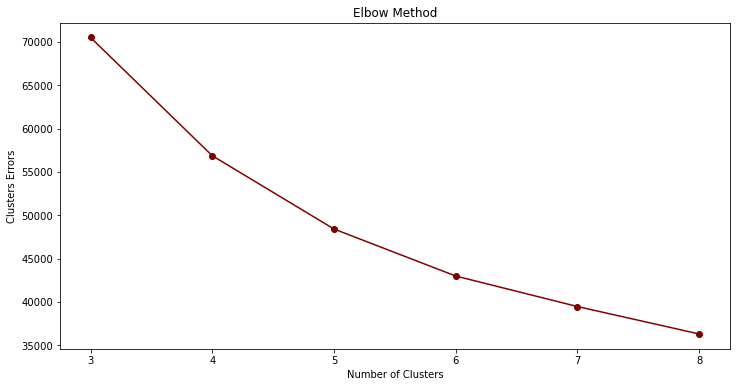

In [66]:
# Plotting graph of Elbow Method 

plt.figure(figsize=(12,6))
plt.plot(range(3,9), wcss, c ='#800000', marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Clusters Errors')
plt.show()

# Inertia or Sum of Squared Errors within the Clusters is also known as the Cluster Errors

# CLuster error will decrease after some Clusters but 

### Inference of Elbow Method:

The sum of squared distances of each data point within a cluster from its respective centroid is called the inertia. The K at which the inertia stops to drop significantly (using the above elbow method) is the best K.

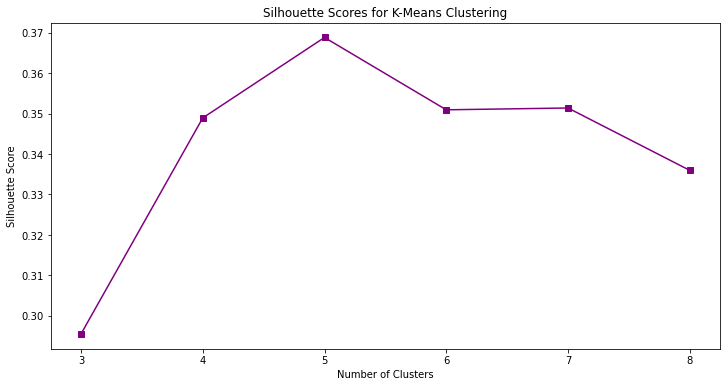

In [67]:
# Plotting the Silhouette Score for the clusters found from K-Means and Agglomerative Clustering

plt.figure(figsize=(12,6))
plt.plot(range(3,9), sil_kmeans, marker='s', c='purple')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

#### 5 turns out to be the optimal number clusters for an effective segmentation

### Segment Distribution

Segment distribution gives the percentage of values in each Segment

### Taking Clsuters for K = 4,5, 6,7,8

In [68]:
KM_3 = KMeans(n_clusters = 3, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)
KM_4 = KMeans(n_clusters = 4, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)
KM_5 = KMeans(n_clusters = 5, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)
KM_6 = KMeans(n_clusters = 6, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)
KM_7 = KMeans(n_clusters = 7, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)
KM_8 = KMeans(n_clusters = 8, n_init = 100, init='k-means++', random_state = 0).fit(X_PCA_6)

In [69]:
# Appending the Cluster labels to the Original Data: (not to Standardized data)

original_df = df_unscaled.copy()
original_df['cluster_3'] = KM_3.labels_
original_df['cluster_4'] = KM_4.labels_
original_df['cluster_5'] = KM_5.labels_
original_df['cluster_6'] = KM_6.labels_
original_df['cluster_7'] = KM_7.labels_
original_df['cluster_8'] = KM_8.labels_

In [70]:
# the new data set has Original variables + the Cluster Labels from each of the clusters got from K-Means

original_df.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,Monthly_Avg_Purchase,Monthly_Avg_Cash,Limit_Usage,Pay_to_MinimumPay,Purchase_Type_both,Purchase_Type_cash,Purchase_Type_installment,Purchase_Type_oneoff,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,0.000000,7.950000,0.000000,0.040901,1.446508,0,0,1,0,2,1,1,1,2,2
1,0.909091,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,0.222222,0.000000,536.912124,0.457495,3.826241,0,1,0,0,1,0,4,4,1,5
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,0.000000,64.430833,0.000000,0.332687,0.991682,0,0,0,1,0,3,2,0,3,4
3,0.636364,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,124.916667,17.149001,0.222223,0.000000,0,0,0,1,1,3,2,0,3,4
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,0.000000,1.333333,0.000000,0.681429,2.771075,0,0,0,1,1,3,2,0,3,4


In [71]:
# Finding the Segment Distribution for cluster K = 3 :

pd.Series.sort_index(original_df.cluster_3.value_counts())/sum(original_df.cluster_3.value_counts())

0    0.307709
1    0.446034
2    0.246257
Name: cluster_3, dtype: float64

In [72]:
# Segment Distribution for cluster K = 4 :

pd.Series.sort_index(original_df.cluster_4.value_counts())/sum(original_df.cluster_4.value_counts())

0    0.271508
1    0.247933
2    0.282235
3    0.198324
Name: cluster_4, dtype: float64

In [73]:
# Segment Distribution for cluster K = 5 :

pd.Series.sort_index(original_df.cluster_5.value_counts())/sum(original_df.cluster_5.value_counts())

0    0.087486
1    0.245698
2    0.188603
3    0.268939
4    0.209274
Name: cluster_5, dtype: float64

In [74]:
# Segment Distribution for cluster K = 6 :

pd.Series.sort_index(original_df.cluster_6.value_counts())/sum(original_df.cluster_6.value_counts())

0    0.185810
1    0.240782
2    0.085251
3    0.194302
4    0.199441
5    0.094413
Name: cluster_6, dtype: float64

In [75]:
# Segment Distribution for cluster K = 7 :

pd.Series.sort_index(original_df.cluster_7.value_counts())/sum(original_df.cluster_7.value_counts())

0    0.193966
1    0.198101
2    0.240894
3    0.185810
4    0.094972
5    0.085922
6    0.000335
Name: cluster_7, dtype: float64

In [76]:
# Segment Distribution for cluster K = 8 :

pd.Series.sort_index(original_df.cluster_8.value_counts())/sum(original_df.cluster_8.value_counts())

0    0.181341
1    0.095084
2    0.212067
3    0.080000
4    0.150726
5    0.183911
6    0.000335
7    0.096536
Name: cluster_8, dtype: float64

### Profiling


#### Step 1 of Profiling:
    
    Finding how many observations or records are present in each segment

In [77]:
# Step 1a: Get the total size of the cluster:
original_df.cluster_3.size

# Step 1b: Get the break up of the values in each segment:
# which gives how many observations are there in each of the respective segment:

original_df.cluster_3.value_counts()

1    3992
0    2754
2    2204
Name: cluster_3, dtype: int64

In [78]:
# by using the Sort Index provides:
# the value counts based on the Segment Label (0,1,2 depending upon the K-value) in the index
# and not based on the highest value within the segments

pd.Series.sort_index(original_df.cluster_3.value_counts())

0    2754
1    3992
2    2204
Name: cluster_3, dtype: int64

Repeat the above two steps for other clusters K = 4 to K = 8 and then combine all into a single array.

In [79]:
# combining the size for each cluster K value into one single array:

size=pd.concat([pd.Series(original_df.cluster_3.size), pd.Series.sort_index(original_df.cluster_3.value_counts()), pd.Series.sort_index(original_df.cluster_4.value_counts()),
           pd.Series.sort_index(original_df.cluster_5.value_counts()), pd.Series.sort_index(original_df.cluster_6.value_counts()),
           pd.Series.sort_index(original_df.cluster_7.value_counts()), pd.Series.sort_index(original_df.cluster_8.value_counts())])

In [80]:
# Segment Size:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])

# Segment Distribtuion % wise:
Seg_Pct = pd.DataFrame(size/original_df.cluster_3.size, columns=['Seg_Pct'])

In [81]:
# Taking Transpose of Segment Percentage :
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,2,3,4,0,1,2,3,4,5,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.307709,0.446034,0.246257,0.271508,0.247933,0.282235,0.198324,0.087486,0.245698,0.188603,0.268939,0.209274,0.18581,0.240782,0.085251,0.194302,0.199441,0.094413,0.193966,0.198101,0.240894,0.18581,0.094972,0.085922,0.000335,0.181341,0.095084,0.212067,0.08,0.150726,0.183911,0.000335,0.096536


In [82]:
# Concatenating the Segment Size and Segment Percentage:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,2,3,4,0,1,2,3,4,5,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,2754.000000,3992.000000,2204.000000,2430.000000,2219.000000,2526.000000,1775.000000,783.000000,2199.000000,1688.000000,2407.000000,1873.000000,1663.00000,2155.000000,763.000000,1739.000000,1785.000000,845.000000,1736.000000,1773.000000,2156.000000,1663.00000,850.000000,769.000000,3.000000,1623.000000,851.000000,1898.000000,716.00,1349.000000,1646.000000,3.000000,864.000000
Seg_Pct,1.0,0.307709,0.446034,0.246257,0.271508,0.247933,0.282235,0.198324,0.087486,0.245698,0.188603,0.268939,0.209274,0.18581,0.240782,0.085251,0.194302,0.199441,0.094413,0.193966,0.198101,0.240894,0.18581,0.094972,0.085922,0.000335,0.181341,0.095084,0.212067,0.08,0.150726,0.183911,0.000335,0.096536


For each of the variable :  find the overall average and the inidividual segment wise average

#### Step 2 of Profiling:

      For each of the variable :  find the overall average and the inidividual segment wise average
      
A good indication of the distribution of data is the mean value, hence will find the average value for each variable and for each cluster.

In [83]:
# Overall each variables wise Avg:
original_df.apply(np.mean).T

BALANCE_FREQUENCY                      0.878083
PURCHASES_FREQUENCY                    0.490351
ONEOFF_PURCHASES_FREQUENCY             0.202458
PURCHASES_INSTALLMENTS_FREQUENCY       0.364437
CASH_ADVANCE_FREQUENCY                 0.134017
CASH_ADVANCE_TRX                       3.079330
PURCHASES_TRX                         14.151385
CREDIT_LIMIT                        4474.419279
PRC_FULL_PAYMENT                       0.153715
Monthly_Avg_Purchase                  80.556556
Monthly_Avg_Cash                      85.248449
Limit_Usage                            0.385243
Pay_to_MinimumPay                      5.517874
Purchase_Type_both                     0.309944
Purchase_Type_cash                     0.228156
Purchase_Type_installment              0.252514
Purchase_Type_oneoff                   0.209385
cluster_3                              0.938547
cluster_4                              1.407374
cluster_5                              2.266816
cluster_6                              2

In [84]:
# Grouping-by over each cluster to find the Segment wise average for each variable
original_df.groupby('cluster_3').apply(np.mean).T

cluster_3,0,1,2
BALANCE_FREQUENCY,0.959356,0.860304,0.808732
PURCHASES_FREQUENCY,0.851203,0.123592,0.703741
ONEOFF_PURCHASES_FREQUENCY,0.508175,0.101565,0.003193
PURCHASES_INSTALLMENTS_FREQUENCY,0.618167,0.023202,0.665453
CASH_ADVANCE_FREQUENCY,0.081234,0.225745,0.033829
CASH_ADVANCE_TRX,1.938635,5.206663,0.651543
PURCHASES_TRX,33.395025,2.335671,11.506806
CREDIT_LIMIT,5964.085041,4178.075893,3149.765601
PRC_FULL_PAYMENT,0.213544,0.046870,0.272478
Monthly_Avg_Purchase,194.233850,22.115190,44.363572


In [85]:
# Concatinating the above two averages:

Profiling_output = pd.concat([original_df.apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_3').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_4').apply(lambda x: x.mean()).T,
                original_df.groupby('cluster_5').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_6').apply(lambda x: x.mean()).T,
                original_df.groupby('cluster_7').apply(lambda x: x.mean()).T, 
                original_df.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [86]:
# To drop the columns indicating different clusters
Profiling_output.drop(index=['cluster_'+str(i) for i in range(3,9)], inplace=True)

In [87]:
# Combining the outputs from steps 1 and 2: 
# Concatenating the segment size, segment distribution, the overall averages, and the individual segment-wise average 

Profiling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profiling_output], axis=0)

# Adding column names

Profiling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [88]:
Profiling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6,KM7_1,KM7_2,KM7_3,KM7_4,KM7_5,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,2754.000000,3992.000000,2204.000000,2430.000000,2219.000000,2526.000000,1775.000000,783.000000,2199.000000,1688.000000,2407.000000,1873.000000,1663.000000,2155.000000,763.000000,1739.000000,1785.000000,845.000000,1736.000000,1773.000000,2156.000000,1663.000000,850.000000,769.000000,3.000000,1623.000000,851.000000,1898.000000,716.000000,1349.000000,1646.000000,3.000000,864.000000
Seg_Pct,1.000000,0.307709,0.446034,0.246257,0.271508,0.247933,0.282235,0.198324,0.087486,0.245698,0.188603,0.268939,0.209274,0.185810,0.240782,0.085251,0.194302,0.199441,0.094413,0.193966,0.198101,0.240894,0.185810,0.094972,0.085922,0.000335,0.181341,0.095084,0.212067,0.080000,0.150726,0.183911,0.000335,0.096536
BALANCE_FREQUENCY,0.878083,0.959356,0.860304,0.808732,0.896603,0.806567,0.964410,0.819284,0.965084,0.808227,0.814763,0.959171,0.876588,0.820441,0.814531,0.964010,0.931366,0.872906,0.977296,0.929295,0.872790,0.814448,0.820441,0.981561,0.964547,0.575758,0.960825,0.978271,0.886082,0.964318,0.940903,0.935179,0.575758,0.329135
PURCHASES_FREQUENCY,0.490351,0.851203,0.123592,0.703741,0.059167,0.698351,0.842942,0.318844,0.334245,0.697514,0.317885,0.841366,0.016729,0.319044,0.701167,0.322205,0.736773,0.003110,0.963799,0.734727,0.002554,0.701306,0.319044,0.967974,0.316332,0.000000,0.759913,0.965866,0.764956,0.332838,0.356299,0.003924,0.000000,0.180602
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.508175,0.101565,0.003193,0.023003,0.003250,0.470097,0.316294,0.167086,0.002369,0.316585,0.468594,0.007292,0.318844,0.000387,0.159869,0.298989,0.001222,0.753636,0.296872,0.000893,0.000387,0.318844,0.756364,0.157430,0.000000,0.308528,0.754286,0.000000,0.162776,0.356052,0.001434,0.000000,0.081174
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.618167,0.023202,0.665453,0.037240,0.660496,0.673149,0.002933,0.216245,0.660511,0.001554,0.672065,0.010490,0.000000,0.665046,0.206047,0.580055,0.001887,0.780169,0.577706,0.001661,0.665201,0.000000,0.784100,0.201838,0.000000,0.601486,0.776255,0.728104,0.218863,0.000000,0.002435,0.000000,0.095201
CASH_ADVANCE_FREQUENCY,0.134017,0.081234,0.225745,0.033829,0.309514,0.032065,0.085899,0.089688,0.564818,0.031467,0.076110,0.061709,0.219431,0.077118,0.031916,0.566587,0.068832,0.223933,0.059998,0.069108,0.222252,0.032056,0.077318,0.060822,0.566471,0.138889,0.073128,0.056735,0.036382,0.574242,0.097537,0.238552,0.138889,0.031967
CASH_ADVANCE_TRX,3.079330,1.938635,5.206663,0.651543,7.378601,0.611086,2.028504,1.774648,16.568327,0.594361,1.416469,1.238887,4.221570,1.435959,0.600464,16.601573,1.355377,4.307563,1.378698,1.365207,4.269600,0.609926,1.439567,1.395294,16.539662,2.000000,1.438694,1.273796,0.688620,16.986034,1.840623,4.641555,2.000000,0.628472
PURCHASES_TRX,14.151385,33.395025,2.335671,11.506806,1.104527,11.393420,34.614169,6.340006,9.366564,11.410186,6.299473,34.494961,0.302723,6.353885,11.389791,8.568807,19.509206,0.058824,60.324118,19.387391,0.050197,11.398887,6.341858,60.410447,8.371912,0.000000,20.340739,59.675511,12.601159,9.155740,7.153825,0.068044,0.000000,3.035880
CREDIT_LIMIT,4474.419279,5964.085041,4178.075893,3149.765601,4361.765879,3140.506257,5902.016203,4264.611353,7439.591315,3126.640920,4149.606132,5800.620245,3405.627916,4145.481149,3130.989969,7479.292267,4441.887826,3440.891365,8084.852071,4407.974038,3429.662203,3133.712145,4145.180488,8123.058824,7448.244473,10333.333333,4389.059106,8130.669800,3011.159141,7604.469274,3974.834558,3462.980964,10333.333333,4340.637831


In [89]:
# Exporting the output:
Profiling_output_final.to_csv('Profiling_output_final.csv')

### Conclusion from Profiling and fctor loadings can be accessed in the excel file in the project folder

---